In [47]:
import pandas as pd
import tarfile
from tqdm import tqdm
import json
import numpy as np
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [20]:
import transformers
print(transformers.__version__)

In [3]:
%pip install transformers --upgrade

  Using cached transformers-4.25.1-py3-none-any.whl (5.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 43.2 MB/s eta 0:00:00
  Using cached tokenizers-0.13.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [21]:
from transformers import DebertaTokenizerFast, TFDebertaModel

In [22]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
numpyArray = np.load('../Jiro/features.npy')
np.load = np_load_old
ratings_ = df = pd.DataFrame(numpyArray, columns = ['user_id','business_id','stars','text'])


In [23]:
ratingsnew = ratings_.head(10000)
# ratingsnew["stars"].astype(float).round()

for count in range(len(ratingsnew.text)):
    ratingsnew.at[count, 'text'] = " ".join(ratingsnew.at[count, 'text'])

ratingsnew['text'] = ratingsnew['text'].astype(str)
print(ratings_.head(1))

/tmp/ipykernel_24713/3368612200.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratingsnew['text'] = ratingsnew['text'].astype(str)


In [24]:
df_features = ratingsnew
df_features["user_id"]  = df_features['user_id'].astype("category").cat.codes
df_features["business_id"]  = df_features['business_id'].astype("category").cat.codes


/tmp/ipykernel_24713/2687010449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["user_id"]  = df_features['user_id'].astype("category").cat.codes
/tmp/ipykernel_24713/2687010449.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["business_id"]  = df_features['business_id'].astype("category").cat.codes


In [48]:
train_df, test_df = train_test_split(df_features, test_size = 0.2)

y_train = tf.convert_to_tensor(train_df["stars"],dtype = "float")
y_test = tf.convert_to_tensor(test_df["stars"],dtype = "float")


In [49]:
tokenizer = DebertaTokenizerFast.from_pretrained('microsoft/deberta-base')
debertaBert = TFDebertaModel.from_pretrained('microsoft/deberta-base')

All model checkpoint layers were used when initializing TFDebertaModel.

All the layers of TFDebertaModel were initialized from the model checkpoint at microsoft/deberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaModel for predictions without further training.


In [50]:
x_train = tokenizer(
    text=train_df.text.tolist(),
    add_special_tokens=True,
    max_length=120,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=test_df.text.tolist(),
    add_special_tokens=True,
    max_length=120,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [52]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [33]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [53]:
max_len = 120
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = debertaBert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(20,activation = 'linear')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [54]:
optimizer = Adam(
    learning_rate=5e-05, 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = MeanSquaredError()
metric = MeanSquaredError()
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [MeanSquaredError(),MeanAbsolutePercentageError()])

In [55]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=2,
    batch_size=36
)

Epoch 1/2
223/223 [==============================] - 1445s 6s/step - loss: 4.8566 - mean_squared_error: 4.8561 - mean_absolute_percentage_error: 50.2321 - val_loss: 3.2037 - val_mean_squared_error: 3.1996 - val_mean_absolute_percentage_error: 40.2387
Epoch 2/2
223/223 [==============================] - 1404s 6s/step - loss: 3.3063 - mean_squared_error: 3.3061 - mean_absolute_percentage_error: 39.9466 - val_loss: 2.7278 - val_mean_squared_error: 2.7234 - val_mean_absolute_percentage_error: 37.1662


In [56]:
predicted_raw = model.predict({'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']})
predicted_raw[0]

250/250 [==============================] - 320s 1s/step


array([3.8690703, 2.5538368, 1.3030386, 1.3228643, 3.2824686, 4.7626166,
       2.5232413, 2.3409605, 4.3311543, 3.1297278, 3.950972 , 2.5014076,
       0.9341877, 4.0647435, 1.8294361, 1.9859731, 2.2874024, 3.9332557,
       2.5586827, 1.9963276], dtype=float32)

In [57]:
y_train[0]

<tf.Tensor: shape=(), dtype=float32, numpy=3.0>

In [58]:
train_history.history

{'loss': [4.856601238250732, 3.3063392639160156],
 'mean_squared_error': [4.856143474578857, 3.3061487674713135],
 'mean_absolute_percentage_error': [50.23214340209961, 39.946571350097656],
 'val_loss': [3.2036819458007812, 2.72780704498291],
 'val_mean_squared_error': [3.19964337348938, 2.723433017730713],
 'val_mean_absolute_percentage_error': [40.23869323730469, 37.16620635986328]}

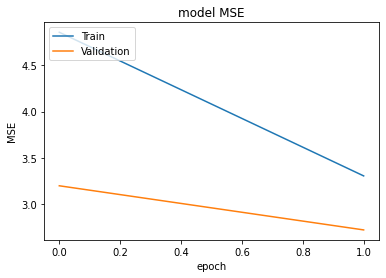

In [59]:
plt.plot(train_history.history['mean_squared_error'])
plt.plot(train_history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [60]:
user_id = test_df['user_id'].tolist()[0]
print(user_id)


3628


In [61]:
newVector = np.array(predicted_raw[0])
print(newVector)
modelRec.user_factors[user_id]

[3.8690703 2.5538368 1.3030386 1.3228643 3.2824686 4.7626166 2.5232413
 2.3409605 4.3311543 3.1297278 3.950972  2.5014076 0.9341877 4.0647435
 1.8294361 1.9859731 2.2874024 3.9332557 2.5586827 1.9963276]


array([ 1.6327069 , -1.1186224 , -0.51947415,  1.8651513 , -1.5703689 ,
        0.63484627,  0.4026803 , -0.8803735 , -0.26417908,  0.22944403,
       -0.12487555, -0.24278536, -0.13926682,  1.871646  ,  1.6769218 ,
       -0.32197753,  0.79706585,  0.56324595,  0.19044511,  0.16101734],
      dtype=float32)

In [62]:
modelRec.recommend(user_id,data_conf[user_id], N = 20)

(array([ 365, 2238,  894, 3574,  227, 2173, 2664, 3060, 3345, 2285,  147,
         260, 1842, 3049, 1392,  807, 2549,  799, 2336, 3562], dtype=int32),
 array([0.49891418, 0.4925411 , 0.478934  , 0.44845256, 0.40253654,
        0.37041733, 0.32801273, 0.31899872, 0.31639338, 0.30975065,
        0.30439156, 0.29587573, 0.29384026, 0.29287043, 0.2916321 ,
        0.28546637, 0.28343126, 0.2813313 , 0.2806907 , 0.27941906],
       dtype=float32))

In [63]:
modelRec.user_factors[user_id] = newVector
print(modelRec.recommend(user_id,data_conf[user_id], N =20))

(array([ 988,  926, 2293, 2580,  982, 3049,  900, 3286, 3251,   30, 1540,
       1007,  630,  752, 1998,  193, 2689, 3551, 3750, 3611], dtype=int32), array([1.248483  , 1.1825048 , 1.1735963 , 1.1502202 , 1.1359893 ,
       1.1031394 , 1.0633372 , 1.0319003 , 1.0169922 , 0.9854347 ,
       0.9522978 , 0.95222306, 0.948167  , 0.9355012 , 0.93427306,
       0.9127747 , 0.9102833 , 0.8984913 , 0.8866327 , 0.8834594 ],
      dtype=float32))
